In [1]:
import anndata
import umap
import xgboost
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import pickle
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import mlflow
import re
regex = re.compile(r"perturbation_experiment_([^_]+)_level")

# base definition and original adata:
if not "adata" in locals():
    levels = ["0", "0.5", "1.0"]
    data_dir = "/data/gene_perturbation_colon_epithelial_scGPT_with_binning_1"
    file_pattern = data_dir + "/perturbation_experiment_{gene}_level_{level}"
    base_fname = file_pattern.format(gene = "JUND", level = "1.0")
    base_embeddings = np.load(f"{base_fname}.embeddings.npy")
    adata = anndata.read_h5ad(f"{base_fname}.h5ad")
    base_df = adata.obs[["tissue", "cell_type", 'sex', 'development_stage',"disease"]].copy()
data_dir = "/data/colon_epithelial_cellxgene_perturbation_4"
file_pattern = data_dir + "/perturbations/perturbation_experiment_{gene}_level_{level}"
genes = set([regex.search(f.name).group(1) for f in list(Path(data_dir+"/perturbations").glob("*.npz"))])
model_filename = "cgboost_on_emebeddings_with_binning_predict_disease_2024-05-05.pkl"
with open(model_filename, "rb") as f:
    model = pickle.load(f)

# load npz file:
# np.load(f"{data_dir}/perturbations/perturbation_experiment_CEACAM5_level_0.embeddings.npz")["emb"].shape

base_df.sample(5, random_state=0)

,tissue,cell_type,sex,development_stage,disease
cell_id,,,,,
N128624_E-GTAGATCAGCTGTTCA,colonic epithelium,enterocyte,female,fifth decade human stage,Crohn disease
N21_Epi_A-CTGAATCTAAGGCG,left colon,enterocyte,female,human adult stage,normal
N124246_L-AACAACCAGTATTAGG,lamina propria of mucosa of colon,brush cell,male,fourth decade human stage,Crohn disease
N175041_N2-TTAGGACGTGGGTATG,left colon,enterocyte,male,seventh decade human stage,Crohn disease
N51_Epi_B-GCATGCGGTCTGCGGT,caecum,enterocyte,male,human adult stage,normal


In [2]:
try:
    perturbation_df = pd.read_parquet("perturbation_df_4.parquet")
except FileNotFoundError:
    base_df["disease_proba"] = model.predict_proba(base_embeddings)[:, 0]
    naming = {0: "KO", 5.0 : "OE"}
    dfs = []
    genes_bar = tqdm(genes, desc="Calculating perturbation effect")
    for gene in genes_bar:
        for level in [0, 5.0]:
            df = base_df.copy().assign(gene = gene, level=naming[level])
            filename = file_pattern.format(gene = gene, level = level) + ".embeddings.npz"
            emb = np.load(filename)["emb"]
            df["proba_perturbed"] = model.predict_proba(emb)[:,0]
            dfs.append(df)
    perturbation_df = pd.concat(dfs)
    perturbation_df.sample(10, random_state=42)
    perturbation_df["proba_disease_after_pertrubation"] = perturbation_df["proba_perturbed"] - perturbation_df["disease_proba"]
    perturbation_df.to_parquet("perturbation_df_4.parquet")

perturbation_df["delta"] = perturbation_df["proba_disease_after_pertrubation"].abs()


In [3]:
print(perturbation_df.shape)
perturbation_df.sample(5, random_state=0).T

(2542488, 11)


cell_id,I114902_N-CGTTGGGGTAGGACAC,N128624_E-ACGGTTAAGCAACAAT,N46_Epi_A-TAGTGGTGTAGCGCTC,I175041_N1-TAGAGCTGTGCCTGTG,N130084_L-GACCCAGAGCTCCACG
tissue,colon,colonic epithelium,right colon,sigmoid colon,lamina propria of mucosa of colon
cell_type,enterocyte,enterocyte,enterocyte,goblet cell,enterocyte
sex,male,female,male,male,female
development_stage,fourth decade human stage,fifth decade human stage,human adult stage,seventh decade human stage,fifth decade human stage
disease,Crohn disease,Crohn disease,normal,Crohn disease,Crohn disease
disease_proba,0.998494,0.663021,0.032388,0.998746,0.833827
gene,GAPDH,CA2,TSPAN1,JUND,GAPDH
level,OE,OE,KO,KO,OE
proba_perturbed,0.996298,0.666137,0.095032,0.998262,0.384553
proba_disease_after_pertrubation,-0.002197,0.003116,0.062644,-0.000484,-0.449274


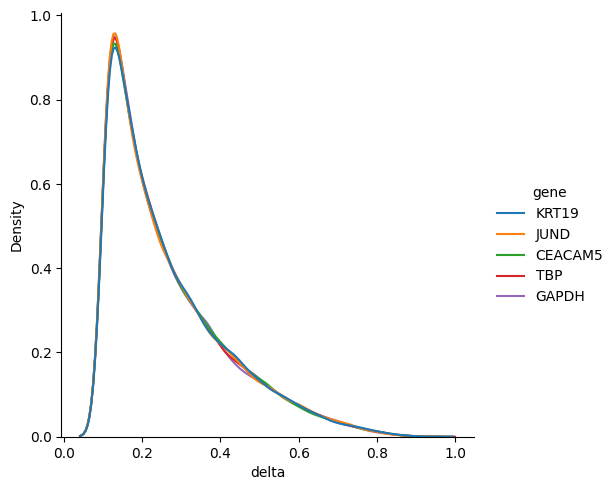

In [4]:
# sns.displot(data=perturbation_df, x="proba_disease_after_pertrubation", hue="gene")
test_genes = ['KRT19', 'JUND', 'CEACAM5', 'TBP', 'GAPDH']
df = perturbation_df.query("level == 'KO'").query("gene in @test_genes").query("abs(proba_disease_after_pertrubation) > 0.1")
sns.displot(data=df, x="delta", hue="gene", kind="kde",)

In [5]:
base_df.cell_type.value_counts()

cell_type
enterocyte              53398
stem cell               18499
goblet cell             15650
epithelial cell          8187
brush cell               1194
enteroendocrine cell      549
paneth cell               311
Name: count, dtype: int64

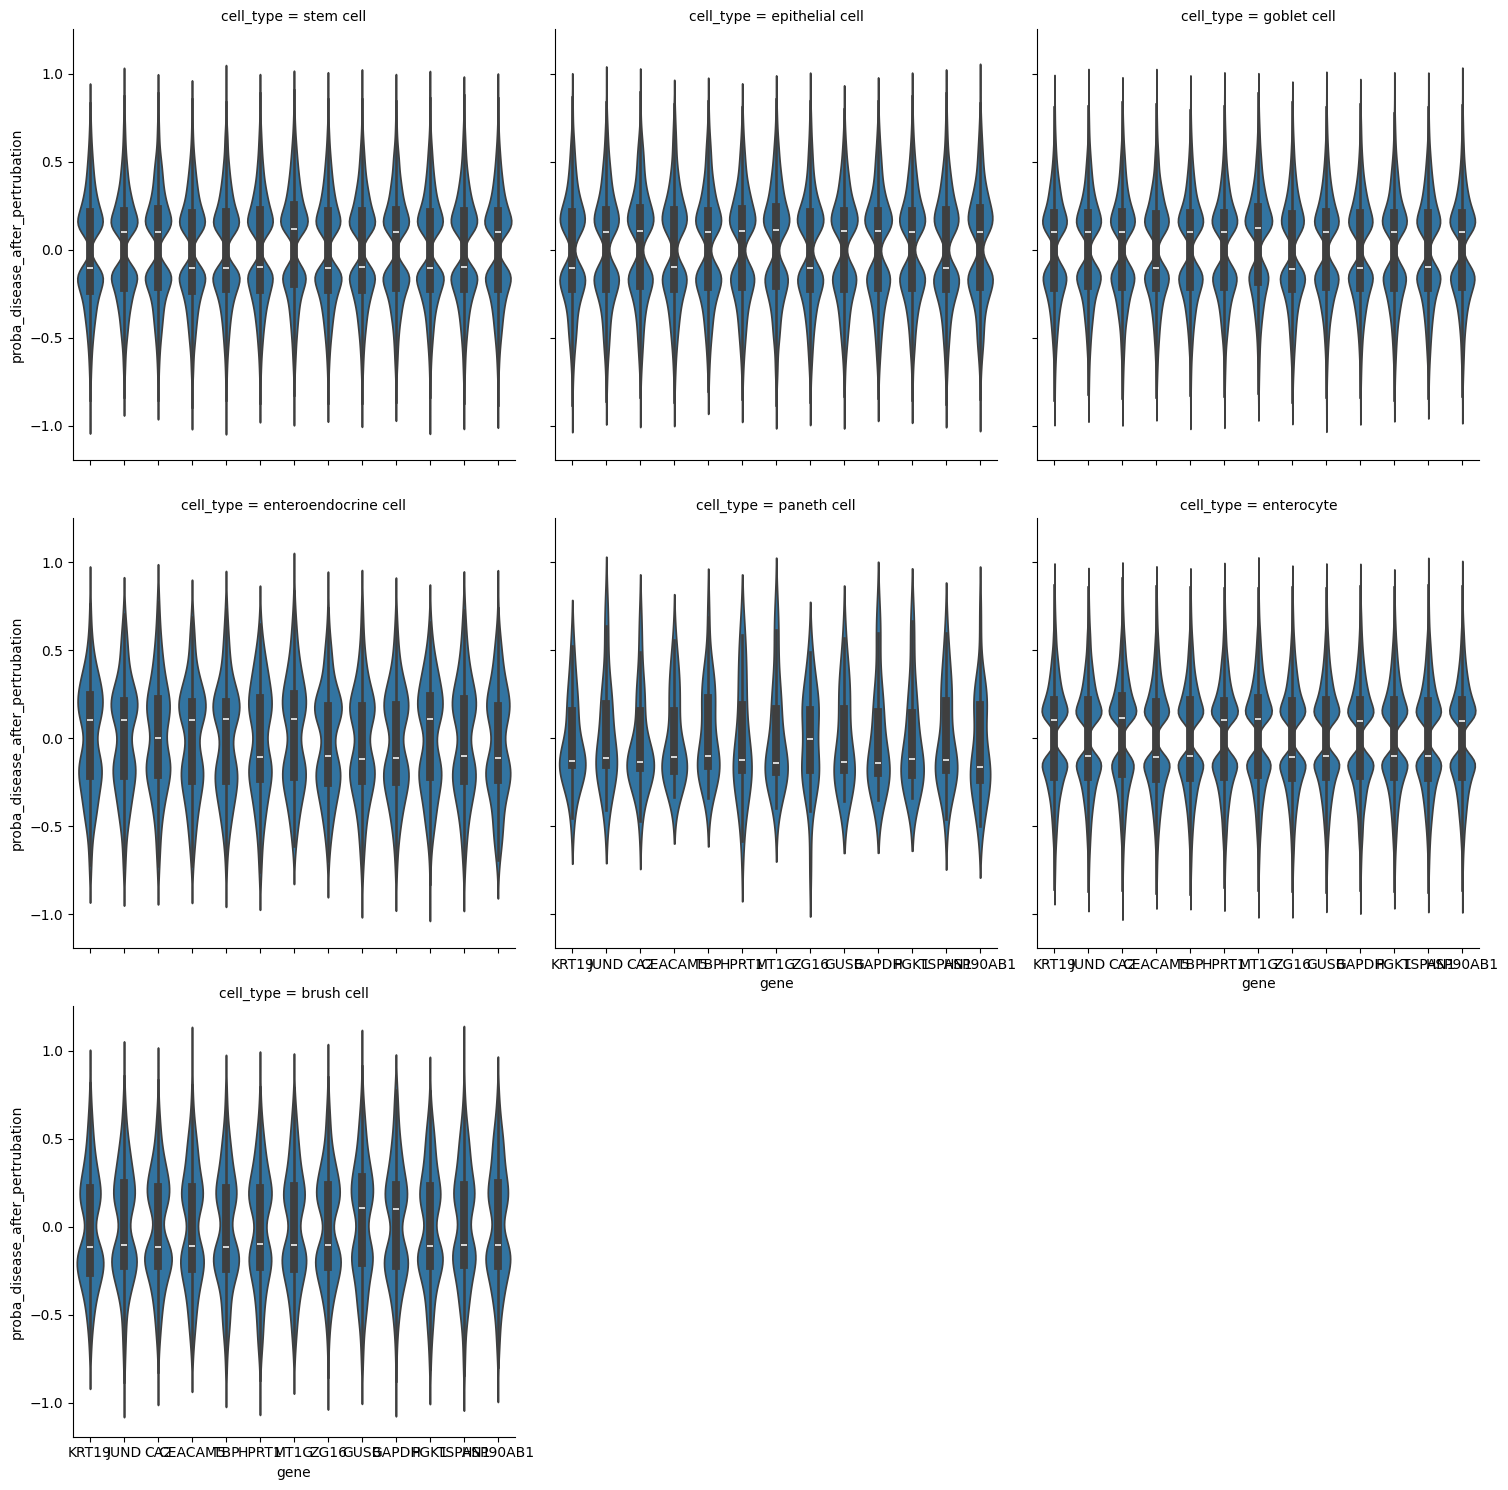

In [6]:
test_genes = ['KRT19', 'JUND', 'CEACAM5', 'TBP', 'GAPDH']
df = perturbation_df.query("level == 'KO'").query("abs(proba_disease_after_pertrubation) > 0.1")
sns.catplot(data = df, x="gene", y="proba_disease_after_pertrubation", col="cell_type", col_wrap=3, kind="violin")

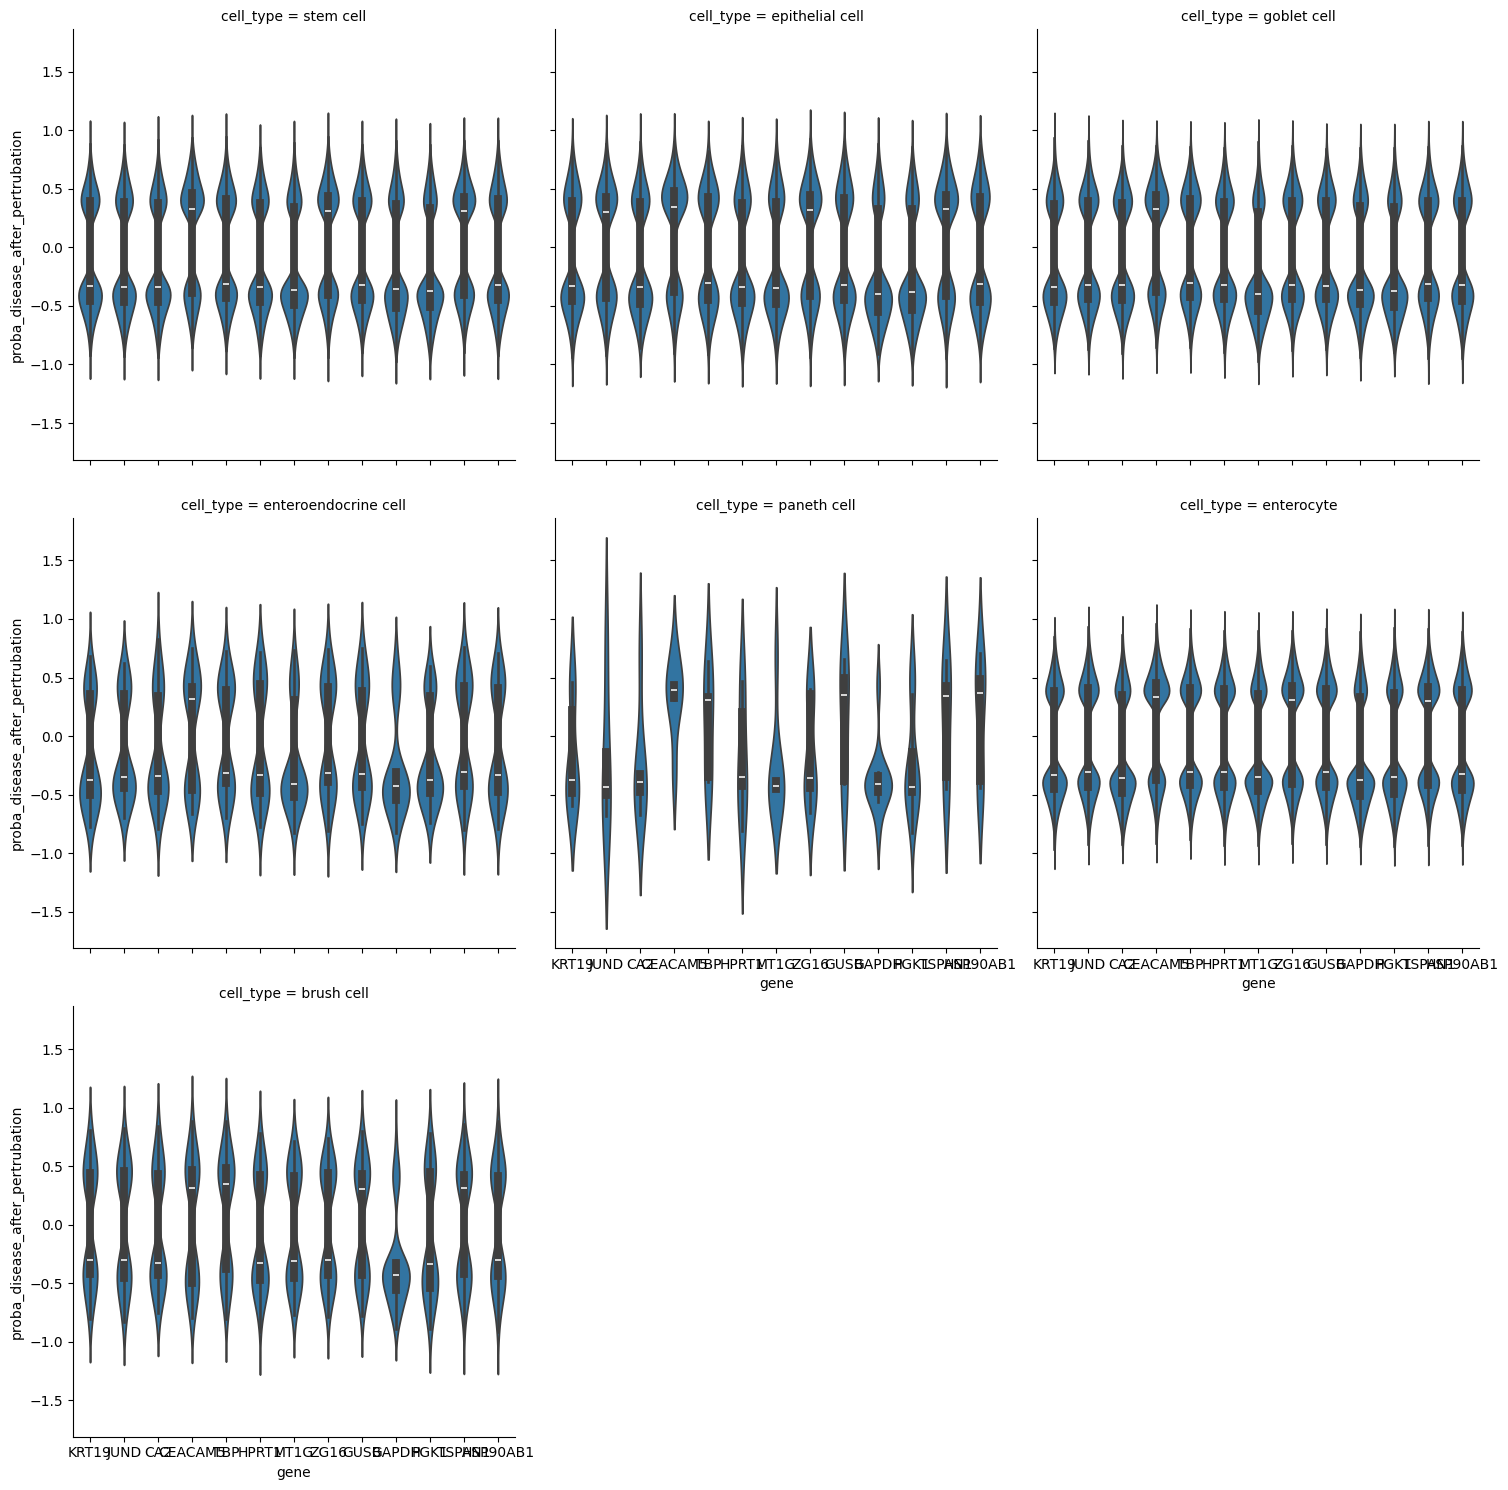

In [7]:
test_genes = ['KRT19', 'JUND', 'CEACAM5', 'TBP', 'GAPDH']
df = perturbation_df.query("level == 'OE'").query("abs(proba_disease_after_pertrubation) > 0.3")
sns.catplot(data = df, x="gene", y="proba_disease_after_pertrubation", col="cell_type", col_wrap=3, kind="violin")

In [16]:
df = (
    perturbation_df.groupby(["gene", "level"])[["proba_disease_after_pertrubation"]]
    .agg(["mean", "std", "median"])
    .droplevel(0, axis=1)
    .reset_index()
    .sort_values("mean")
)

# delta between levels of the same gene:
df.pivot(index="gene", columns="level", values="mean").assign(delta = lambda x: x["OE"] - x["KO"]).sort_values("delta")



level,KO,OE,delta
gene,,,
GAPDH,-0.000142,-0.035019,-0.034877
MT1G,0.008112,-0.025692,-0.033804
PGK1,-0.000876,-0.025128,-0.024252
CA2,0.005725,-0.018474,-0.024199
KRT19,-0.001191,-0.012472,-0.011281
HSP90AB1,-0.000476,-0.009419,-0.008943
HPRT1,-0.000364,-0.008065,-0.007701
JUND,-0.000187,-0.005669,-0.005482
GUSB,-0.000667,-0.004720,-0.004053


/tmp/ipykernel_17016/3339020746.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cell"] = df.index


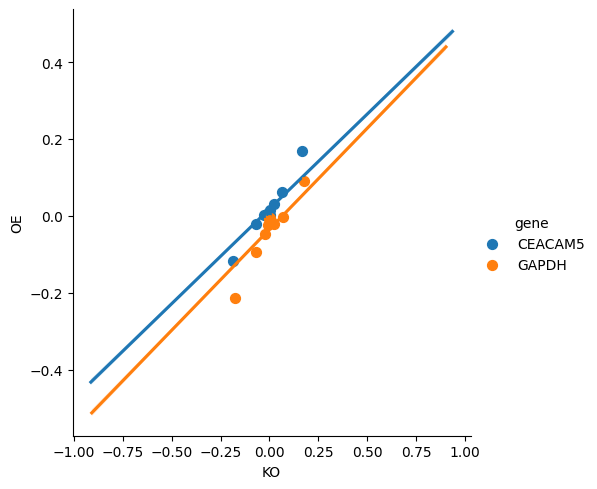

In [41]:
df = perturbation_df.query("gene == ['CEACAM5','GAPDH']")#.query("delta > 0.3")

# sns.catplot(data = df, x="gene", y="proba_disease_after_pertrubation", hue="level", kind="violin")

# sns show correlation between gene expression and disease probability, with col:
# sns.relplot(data = df, x="KO", y="OE", col="gene", kind="scatter")

# I want to rehsape the dataframe to have the level as columns,with the gene as column, the the values as all the delta values:
df["cell"] = df.index
pv = df.pivot(index=["cell","gene"], columns="level", values="proba_disease_after_pertrubation").reset_index()

sns.lmplot(data = pv, x="KO", y="OE", hue="gene", x_bins=10)

In [42]:
perturbation_df

,tissue,cell_type,sex,development_stage,disease,disease_proba,gene,level,proba_perturbed,proba_disease_after_pertrubation,delta
cell_id,,,,,,,,,,,
N105446_L-ATTGTTCCAAACGTGG,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,0.996019,KRT19,KO,0.994889,-0.001130,0.001130
N105446_L-TCGACGGGTGAGACCA,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,0.999010,KRT19,KO,0.998396,-0.000614,0.000614
N105446_L-AGTAACCGTTAAGGGC,lamina propria of mucosa of colon,paneth cell,male,third decade human stage,Crohn disease,0.996615,KRT19,KO,0.997399,0.000784,0.000784
N105446_L-GCAGGCTTCGCTAAAC,lamina propria of mucosa of colon,goblet cell,male,third decade human stage,Crohn disease,0.999778,KRT19,KO,0.999786,0.000008,0.000008
N105446_L-ATCTTCATCTGAGAGG,lamina propria of mucosa of colon,goblet cell,male,third decade human stage,Crohn disease,0.996219,KRT19,KO,0.997468,0.001249,0.001249
...,...,...,...,...,...,...,...,...,...,...,...
N130084_L-GTGGTTACAGTTCCAA,lamina propria of mucosa of colon,brush cell,female,fifth decade human stage,Crohn disease,0.991700,HSP90AB1,OE,0.985194,-0.006506,0.006506
N130084_L-TATCCTATCGTTCATT,lamina propria of mucosa of colon,enterocyte,female,fifth decade human stage,Crohn disease,0.989881,HSP90AB1,OE,0.985371,-0.004511,0.004511
N130084_L-TCATCCGGTATGATCC,lamina propria of mucosa of colon,enterocyte,female,fifth decade human stage,Crohn disease,0.998500,HSP90AB1,OE,0.999564,0.001064,0.001064
